## Property Sales Analysis - Part 1  

In [3]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd 
import numpy as np  
import seaborn as sns 
import re
import matplotlib.pyplot as plt 
# Folium Map 
import folium
import branca.colormap as cmp

from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

In [4]:
pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_context('talk')
sns.set_style('darkgrid', {'font.sans-serif': ['Iosevka']})

In [5]:
print(f"Pandas ver.: {pd.__version__}")
print(f"Numpy ver.: {np.__version__}")
print(f"Seaborn ver.: {sns.__version__}")
print(f"Folium ver.: {folium.__version__}")

Pandas ver.: 1.1.0
Numpy ver.: 1.19.1
Seaborn ver.: 0.10.1
Folium ver.: 0.11.0


In [6]:
# Global variable 
train_file = 'datasets/sherbrooke/comparable_properties_sherbrooke_extract_20201015.csv'
test_file = 'datasets/sherbrooke/comparable_properties_sherbrooke_extract_20201015.csv'

### Dataset summary

In [7]:
def load_dataset(filename, na_val=None, parse_date=False):
    if parse_date:
        to_parse = ['CREATION_DATE','YEAR_BUILD', 'DATE_OF_SALE']
        df = pd.read_csv(train_file, parse_dates=to_parse, na_values=na_val)
    else:
        df = pd.read_csv(train_file, na_values=na_val)
    
    features = df.columns
    target = 'PURCHASE_PRICE'
    
    print("+ Dataset:")
    display(df.head(3))
    print("+ Shape:")
    display(df.shape) 
    print(f"+ Target: {target}")
    print(f"+ Overall Variables Info: ")
    display(pd.DataFrame(df.info(memory_usage='deep')))
    
    return features, target, df

features, target, dataset = load_dataset(train_file, na_val=0, parse_date=True)

+ Dataset:


,id,CREATION_DATE,PURCHASE_PRICE,ADDRESSES_FULL,LATITUDE,LONGITUDE,UNIT_NUMBER,YEAR_BUILD,REVENU_GROSS_ROUNDED,NORMALYZED_EXPENSES_ROUNDED,CAP_RATE,PRICE_PER_UNIT,GROSS_REVENUE_MULTIPLICATOR,NET_REVENUE_MULTIPLICATOR,DATE_OF_SALE,DISTANCE
0,10395,2020-06-20,200000,1101 Rue Louis-St-Laurent Sherbrooke (Les Nati...,45.389,-71.936,2,1967-01-01,17000,5100,6.140,100000.000,11.490,16.300,2018-04-22,0.058
1,19800,2020-07-02,449000,2541 Rue Fisette Sherbrooke (Les Nations) J1K 1E4,45.388,-71.936,6,1967-01-01,37000,14300,5.020,74833.330,12.190,19.920,2017-01-11,0.146
2,89,2020-05-29,124000,2334-2336 Rue Galt O. Sherbrooke (Les Nations)...,45.387,-71.940,3,NaT,11000,6400,4.010,41333.330,10.880,24.910,2019-01-13,0.350


+ Shape:


(605, 16)

+ Target: PURCHASE_PRICE
+ Overall Variables Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           605 non-null    int64         
 1   CREATION_DATE                605 non-null    datetime64[ns]
 2   PURCHASE_PRICE               605 non-null    int64         
 3   ADDRESSES_FULL               605 non-null    object        
 4   LATITUDE                     605 non-null    float64       
 5   LONGITUDE                    605 non-null    float64       
 6   UNIT_NUMBER                  605 non-null    int64         
 7   YEAR_BUILD                   532 non-null    datetime64[ns]
 8   REVENU_GROSS_ROUNDED         605 non-null    int64         
 9   NORMALYZED_EXPENSES_ROUNDED  605 non-null    int64         
 10  CAP_RATE                     605 non-null    float64      

""


In [7]:
print(f"+ Target: ")
target
print(f"+ Overall features:")
features.tolist()

+ Target: 


'PURCHASE_PRICE'

+ Overall features:


['id',
 'CREATION_DATE',
 'PURCHASE_PRICE',
 'ADDRESSES_FULL',
 'LATITUDE',
 'LONGITUDE',
 'UNIT_NUMBER',
 'YEAR_BUILD',
 'REVENU_GROSS_ROUNDED',
 'NORMALYZED_EXPENSES_ROUNDED',
 'CAP_RATE',
 'PRICE_PER_UNIT',
 'GROSS_REVENUE_MULTIPLICATOR',
 'NET_REVENUE_MULTIPLICATOR',
 'DATE_OF_SALE',
 'DISTANCE']

### Missing data summary 

In [8]:
def display_missing(dataset, features, verbose=False):
    if verbose:
        print("+ Missing data: ")
    missing_count = dataset[features].isnull().sum()
    missing_percent = (dataset[features].isnull().sum() / len(dataset) * 100).round(4)
    missing = pd.DataFrame({'feature': features, 'count': missing_count, 'percent': missing_percent,})
    missing.sort_values('count', ascending=False, inplace=True)
    missing.reset_index(drop=True, inplace=True)
    return missing

display_missing(dataset, features, True)

+ Missing data: 


,feature,count,percent
0,YEAR_BUILD,73,12.066
1,id,0,0.000
2,CREATION_DATE,0,0.000
3,PURCHASE_PRICE,0,0.000
4,ADDRESSES_FULL,0,0.000
5,LATITUDE,0,0.000
6,LONGITUDE,0,0.000
7,UNIT_NUMBER,0,0.000
8,REVENU_GROSS_ROUNDED,0,0.000
9,NORMALYZED_EXPENSES_ROUNDED,0,0.000


### Statistics summary 

In [9]:
def display_stats(df):
    date_feats = ['CREATION_DATE','YEAR_BUILD', 'DATE_OF_SALE']
    
    print(f"\n+ Dates Min & Max: ")
    date_feats_df = pd.DataFrame(
        {'OLDEST ': df[date_feats].min(),
         'NEAREST ': df[date_feats].max(),
        })
    display(date_feats_df)
    
    print(f"\n+ Statistics: ")
    display(df.describe())
    
    
display_stats(dataset)


+ Dates Min & Max: 


,OLDEST,NEAREST
CREATION_DATE,2020-05-29,2020-07-17
YEAR_BUILD,1879.000,2018.000
DATE_OF_SALE,2016-11-16,2020-05-28



+ Statistics: 


,id,PURCHASE_PRICE,LATITUDE,LONGITUDE,UNIT_NUMBER,YEAR_BUILD,REVENU_GROSS_ROUNDED,NORMALYZED_EXPENSES_ROUNDED,CAP_RATE,PRICE_PER_UNIT,GROSS_REVENUE_MULTIPLICATOR,NET_REVENUE_MULTIPLICATOR,DISTANCE
count,605.000,605.000,605.000,605.000,605.000,532.000,605.000,605.000,605.000,605.000,605.000,605.000,605.000
mean,10652.302,366339.564,45.387,-71.924,4.420,1961.744,33613.223,13405.950,5.639,92009.951,11.420,19.262,7.533
std,6018.797,449734.391,0.061,0.098,5.792,30.649,44722.276,19193.562,1.546,35777.122,2.869,6.838,7.024
min,74.000,62000.000,45.135,-72.193,2.000,1879.000,6000.000,3300.000,1.410,20666.670,5.130,6.910,0.058
25%,5870.000,190000.000,45.381,-71.946,2.000,1945.000,17000.000,5900.000,4.760,65833.330,9.630,15.570,3.309
50%,10819.000,258000.000,45.395,-71.895,3.000,1960.000,22000.000,8400.000,5.460,82960.000,11.230,18.300,4.801
75%,16050.000,389500.000,45.409,-71.879,4.000,1987.000,35000.000,13100.000,6.420,115000.000,12.910,21.020,6.818
max,20113.000,6000000.000,45.643,-71.567,69.000,2018.000,656000.000,246600.000,14.470,231666.670,29.000,70.710,29.973


### Map properties location 

In [10]:
# Helper add comma to amount 
def h_comma(amount):
    orig = amount
    new = re.sub("^(-?\d+)(\d{3})", '\g<1>,\g<2>', amount)
    if orig == new:
        return new
    else:
        return h_comma(new)

In [11]:
# Center point: Lat, Long 
lat_start = (dataset['LATITUDE'].max() + dataset['LATITUDE'].min()) / 2
lon_start = (dataset['LONGITUDE'].max() + dataset['LONGITUDE'].min()) / 2
start_coord = (lat_start, lon_start)

latitude = dataset['LATITUDE']
longitude = dataset['LONGITUDE']
p_price = dataset['PURCHASE_PRICE']
address = dataset['ADDRESSES_FULL']
cap_rate = dataset['CAP_RATE']
units = dataset['UNIT_NUMBER']

mt_map = folium.Map(
    location=start_coord, # Lat, Long 
    zoom_start=11
)
color_map = cmp.LinearColormap(
    ['blue', 'red'],
    vmin=p_price.min(), vmax=p_price.max(),
    index=[p_price.min(), p_price.max()],
    caption='PURCHASE PRICE' 
)

for lat, lon, price, addr, capr, unit in zip(latitude, longitude, p_price, address, cap_rate, units):
    _ = folium.CircleMarker(
        location = [lat, lon],
        color=color_map(price),
        fill=True,
        fill_opacity=1,
        radius = 4,
        tooltip = ('Address: ' + str(addr) + '<br>'
                   'Price: ' + h_comma(str(price)) + '<br>'
                   'Unit no.: ' + str(unit) + '<br>'
                  ),
    ).add_to(mt_map)
    
_ = mt_map.add_child(color_map)


# Display Map - hover: Price
mt_map

### Target Analysis & Enginnering  

In [12]:
def plot_dist(df, feature, title):
    # Grid plot:
    fig = plt.figure(constrained_layout=True, figsize=(16, 10))
    grid = gridspec.GridSpec(ncols=4, nrows=3, figure=fig, hspace=0.4, wspace=0)
    
    # Histogram:
    hist_ax = fig.add_subplot(grid[:2, :2])
    sns.distplot(df.loc[:, feature], 
                 hist=True,
                 kde=True,
                 fit=norm,
                 ax=hist_ax,
                 color='#e74c3c')
    hist_ax.legend(labels=['Normal', 'Actual'])
    hist_ax.set_title('')
    hist_ax.set_xlabel('PURCHASE PRICE')
    hist_ax.set_ylabel('KDE')

    # QQ_plot:
    qq_ax = fig.add_subplot(grid[2:, :2])
    stats.probplot(df.loc[:, feature].fillna(np.mean(df.loc[:, feature])), plot=qq_ax)
    qq_ax.get_lines()[0].set_markerfacecolor('#e74c3c')
    qq_ax.get_lines()[0].set_markersize(12.0)
    qq_ax.set_title('')
    qq_ax.set_xlabel('THEORETICAL QUANTILES')
    qq_ax.set_ylabel('PURCHASE PRICE')
    
    # Box Plot:
    bx_ax = fig.add_subplot(grid[:, 3])
    sns.boxplot(df.loc[:, feature], orient='v', ax=bx_ax, color='#e74c3c')
    bx_ax.set_title('')
    bx_ax.set_ylabel('PURCHASE PRICE')
    bx_ax.set_xlabel('')
    bx_ax.yaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.suptitle(f'{title}', fontsize=20)
    

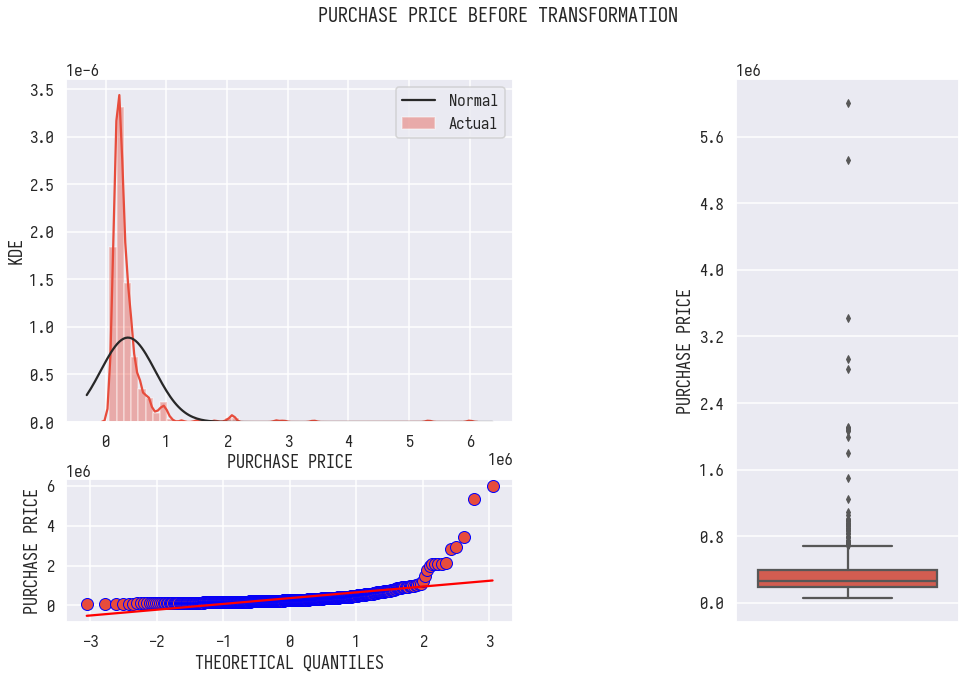

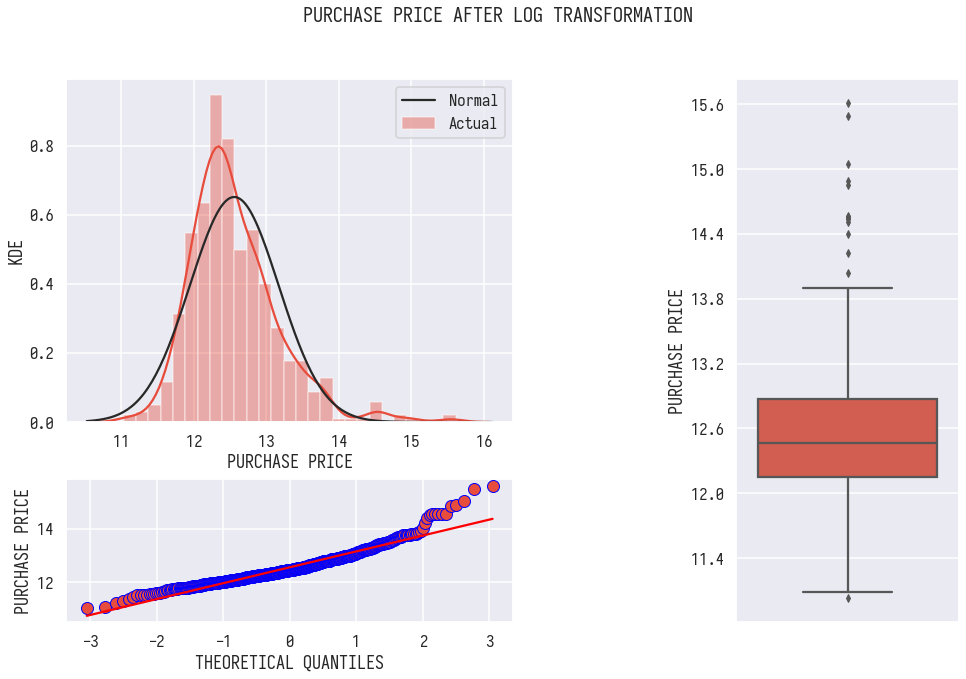

In [13]:
# Plot purchased price 
plot_dist(dataset, target, 'Purchase Price before transformation'.upper())

# Plot log purchased price 
y = np.log1p(dataset[target])
dataset["LOG_PRICE_P"] = np.log1p(dataset[target])
plot_dist(dataset, 'LOG_PRICE_P', 'Purchase Price after Log transformation'.upper())


## Feature Engineering   

- Before going further, we are first interested in the way how can we impute the missing data in YEAR_BUILD. We can approach creating a new feature BUILD_AGE which refers to the age of the property then impute missing value using different imputer algorithms. Then we will evaluate the model and observe the effects of the imputation techniques by comparing their performance using RandomForest.  
- Prior to that as we are going to use the evaluation model, we may need to prepare our features. It is essential to know features distribution to see if there are outliers or they may be skewed, etc..
- To avoid Data Leakage, it is preferably separate the Train and Test sets and the following transformation will be first applied to the Train set.  

In [14]:
# Get build age from year build 
dataset["BUILD_AGE"] = dataset["YEAR_BUILD"].apply(lambda x: (2020 - x) if x > 0 else x)

# Get sale age from date of sale 
sale_age = dataset["DATE_OF_SALE"].apply(lambda x: int(x.split('-')[0]))
dataset["SALE_AGE"] = sale_age.apply(lambda x: (2020 - x) if int(x) > 0 else x)

# Summary
dataset.agg({'BUILD_AGE': ['min', 'max', 'median'],
            'SALE_AGE': ['min', 'max', 'median']})

,BUILD_AGE,SALE_AGE
min,2.000,0.000
max,141.000,4.000
median,60.000,1.000


In [15]:
from sklearn.model_selection import train_test_split

unused_feats = ['id', 'CREATION_DATE', 'PURCHASE_PRICE', 'ADDRESSES_FULL', 'LATITUDE', 'LONGITUDE', 'YEAR_BUILD', 'DATE_OF_SALE'] 
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(unused_feats, axis=1), 
                                                    dataset[target], 
                                                    test_size=.2, 
                                                    random_state=42)

# Double check the proportion of missing values 
print(f"+ Missing summary in X_train {X_train.shape}: ")
display_missing(X_train, X_train.columns, verbose=False).head(3)

print(f"+ Missing summary in X_test {X_test.shape}:")
display_missing(X_test, X_test.columns, verbose=False).head(3)

# Train data summary 
print(f"+ Train data summary:")
X_train.head(3)
# Get features in use 
train_feats = X_train.columns 

+ Missing summary in X_train (484, 11): 


,feature,count,percent
0,BUILD_AGE,61,12.603
1,UNIT_NUMBER,0,0.000
2,REVENU_GROSS_ROUNDED,0,0.000


+ Missing summary in X_test (121, 11):


,feature,count,percent
0,BUILD_AGE,12,9.917
1,UNIT_NUMBER,0,0.000
2,REVENU_GROSS_ROUNDED,0,0.000


+ Train data summary:


,UNIT_NUMBER,REVENU_GROSS_ROUNDED,NORMALYZED_EXPENSES_ROUNDED,CAP_RATE,PRICE_PER_UNIT,GROSS_REVENUE_MULTIPLICATOR,NET_REVENUE_MULTIPLICATOR,DISTANCE,LOG_PRICE_P,BUILD_AGE,SALE_AGE
235,4,42000,14900,4.690,145000.000,13.770,21.330,3.932,13.271,13.000,1
9,2,21000,12000,3.890,117500.000,11.130,25.730,0.683,12.367,59.000,3
227,5,27000,10400,8.620,39400.000,7.200,11.600,3.826,12.191,74.000,1


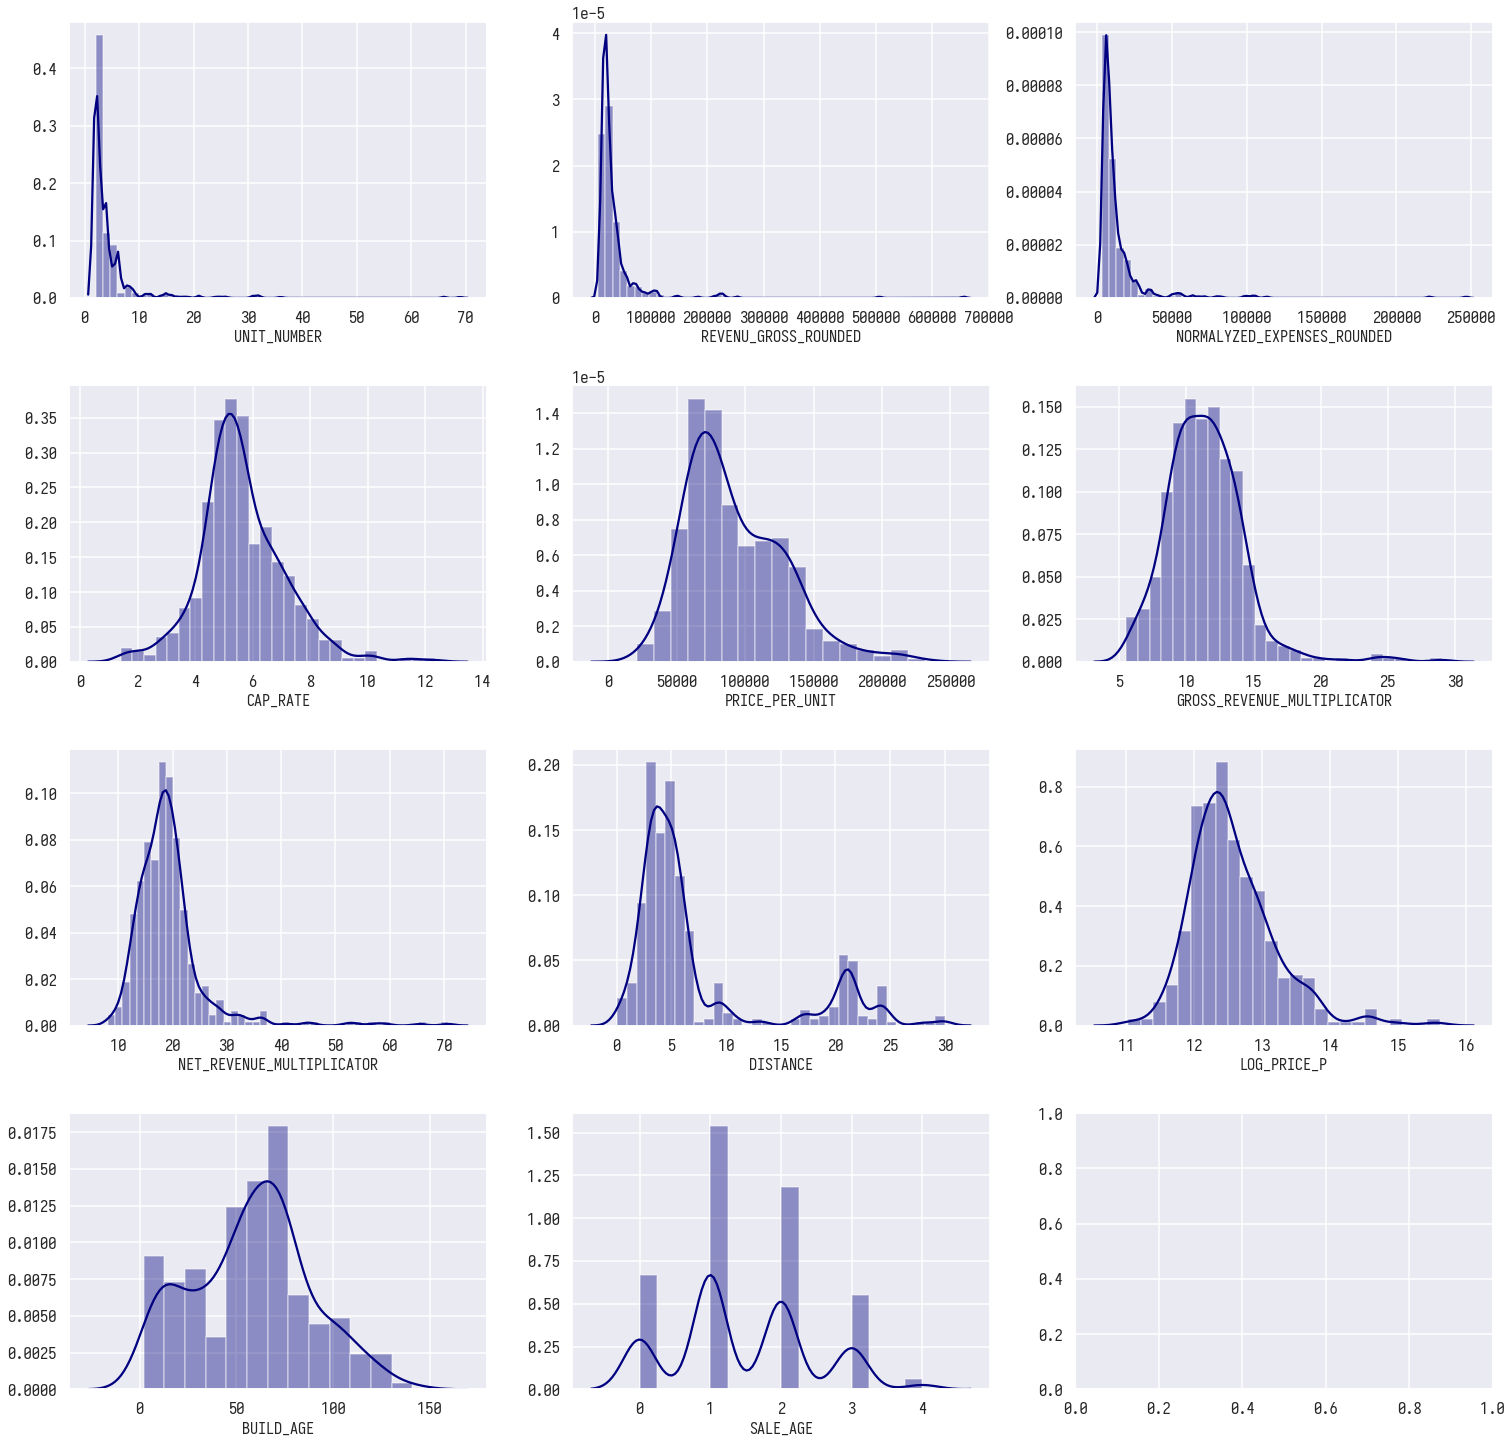

In [16]:
def visualize_dist(df):
    num_cols = df.columns
    cols = 3
    rows = (len(num_cols) // cols) 
    if (len(num_cols) % cols) != 0:
        rows += 1
    fig, axis = plt.subplots(rows, cols, figsize=(7*cols, 5*rows))
    fig.tight_layout(w_pad=2, h_pad=3) 
    for i, col in enumerate(num_cols):
        row = i // cols
        pos = i % cols
        _ = sns.distplot(df[col], ax=axis[row][pos], kde=True, color='navy')
        _ = axis[row][pos].set_title('')
        _ = axis[row][pos].set_xlabel(f'{col}', fontdict={'size': 16})
        _ = axis[row][pos].set_ylabel('')
    plt.show()
    
visualize_dist(X_train)

### Feature Transformation 
- From the distribution, we can spot the presence of outliers in 'UNIT_NUMBER', 'REVENU_GROSS_ROUNDED', 'NORMALYZED_EXPENSES_ROUNDED', 'NET_REVENUE_MULTIPLICATOR', and 'DISTANCE'. In addition to outliers, these features are skewed.  As we do not have enough data and we do not have negative data in these features, we will keep the data as it is and try to apply Log tranformation to address the problem of outliers as well as the skeweness. Finally we will evaluate the effects of the imputation algorithm on the prepared dataset. 
###  Summary 
- We can notice changes in the distribution of the features out of the following plots though we only applied log transformation. Therefore, we can later apply the same transformation in the upcoming pipeline.

In [18]:
def visualize_transform(df, col, transformer):
    fig, axis = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout(w_pad=2, h_pad=10) 

    _ = sns.distplot(df[col], ax=axis[0], kde=True, color='navy')
    axis[0].set_title('Before ' + str(transformer).split('(')[0])
    axis[0].set_xlabel(f'{col}')
    
    trans_col = transformer.fit_transform(df[col])
    _ = sns.distplot(trans_col, ax=axis[1], kde=True, color='navy')
    axis[1].set_title('After ' + str(transformer).split('(')[0])
    axis[1].set_xlabel(f'{col}')
    

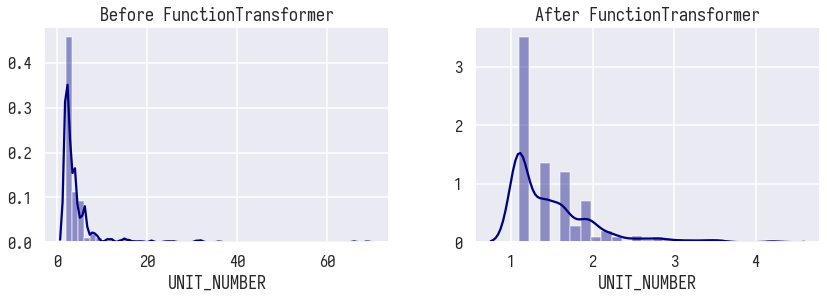

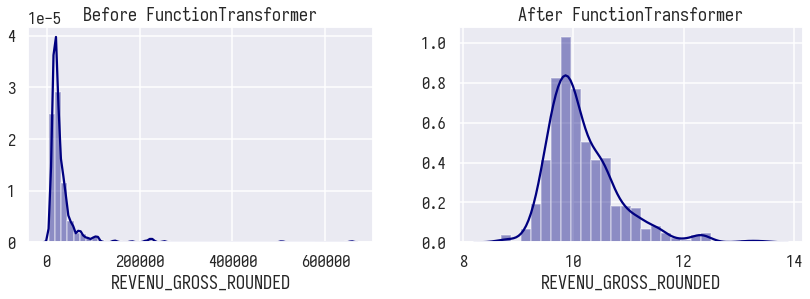

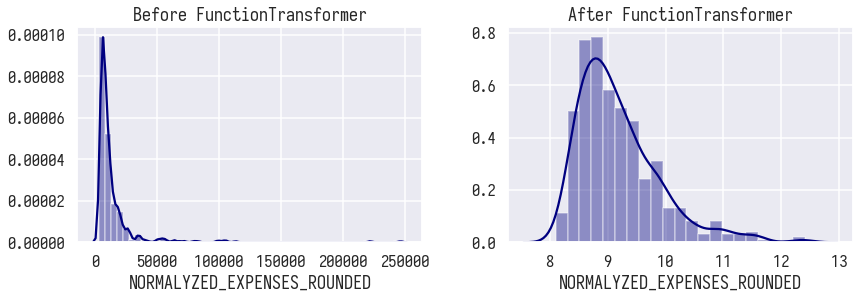

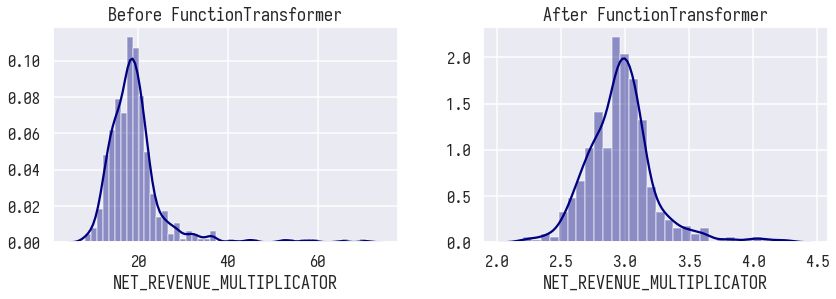

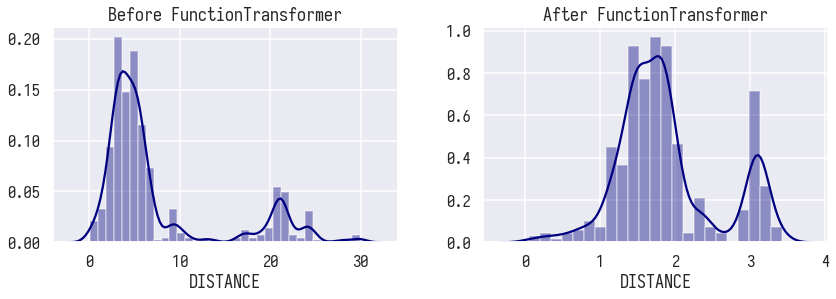

In [19]:
from sklearn.preprocessing import FunctionTransformer

# Select columns that need transformation  
log_tranform_cols = ['UNIT_NUMBER', 'REVENU_GROSS_ROUNDED', 'NORMALYZED_EXPENSES_ROUNDED', 'NET_REVENUE_MULTIPLICATOR', 'DISTANCE']

# Using log tranformation 
for col in log_tranform_cols:
    visualize_transform(X_train, col, FunctionTransformer(lambda x: np.log1p(x)))

In [31]:
# Various Helper libs 
import sklearn as sk
from sklearn.model_selection import (train_test_split, cross_validate, 
                                     GridSearchCV, KFold, cross_val_score)
# Processor libs 
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
# Imputer libs
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
# Model libs 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
# Metrics 
from sklearn.metrics import make_scorer, r2_score, mean_squared_error


### Missing value imputation 
- In the following we are going to evaluate different imputation techniques on the Train set using the RandomForestRegressor. 
### Observation  
- From the following outcome, we are pretty much confident to say that KNN imputer was much effective w.r.t our case. Thus it will be used in the following model validation.

In [41]:
def impute_cv(imputers, X, y):
    # RF is only used for imputation techniques evaluation 
    model_rf = RandomForestRegressor(random_state=42)
    
    impute_scores = pd.DataFrame()
    for i, (name, imputer) in enumerate(imputers.items()):
        estimator = make_pipeline(imputer, model_rf)
        score = cross_val_score(estimator, X, y, scoring=make_scorer(mean_squared_error), cv=kf)
        impute_scores.loc[i, "Imputer"] = name
        impute_scores.loc[i, "RMSE"] = np.sqrt(score).mean()
         
    impute_scores.sort_values(by=['RMSE'], ascending=True, inplace=True)
    impute_scores.reset_index(drop=True, inplace=True)
    
    return impute_scores.round(4)
        
# Setup imputers 
imputers = dict()
imputers["Mean Imputer"] = SimpleImputer(missing_values=np.nan, add_indicator=True, strategy='mean')
imputers["Median Imputer"] = SimpleImputer(missing_values=np.nan, add_indicator=True, strategy='median')
imputers["KNN Imputer"] = KNNImputer(missing_values=np.nan, add_indicator=True)
imputers["Iterative Imputer"] = IterativeImputer(missing_values=np.nan, add_indicator=True, random_state=0, n_nearest_features=5, sample_posterior=True)

impute_res = impute_cv(imputers, X_train, y_train)
display(impute_res)

,Imputer,RMSE
0,KNN Imputer,105908.508
1,Mean Imputer,107227.106
2,Median Imputer,107444.230
3,Iterative Imputer,111360.884


In [42]:
# Setup KNN imputater 
imputer = KNNImputer(n_neighbors=5, weights="uniform")
X_train_imp = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_imp, columns=train_feats)

## Model evaluation 
- Here we are going to evaluate different regression algorithms 
### Observation
- It turns out that the Linear models overfit the training set but it does make sense since the multiple linear regression perhaps suffers from multicollinearity. To avoid this problem we can later apply feature selection based on correlation analysis and we try to implement adjust the regularization coefficient of Ridge and Lasso regressor as it plays a critical role in reducing the model complexity and automatically selecting important features. 
- In the following we discover how the same models behave on the Test set

In [44]:
class TargetTransformer(BaseEstimator, TransformerMixin):
    # No need to call __init__ in this particular case 
    def fit(self, target):
        return self
    # Training: 
    def transform(self, target):
        target_ = target.copy()
        target_ = np.log1p(target_)
        return target_
    # Prediction:
    def inverse_transform(self, target):
        target_ = target.copy()
        target_ = np.expm1(target_)
        return target_

In [45]:
def preprocess(estimators, X, y):
    # Select columns that need transformation  
    log_tranform_cols = ['UNIT_NUMBER', 'REVENU_GROSS_ROUNDED', 'NORMALYZED_EXPENSES_ROUNDED', 'NET_REVENUE_MULTIPLICATOR', 'DISTANCE']
    scale_cols = X.drop(columns=log_tranform_cols).columns.to_list()
    
    # Define Transformer 
    log_trans_pipe = Pipeline( 
        steps=[
            ('log_trans', FunctionTransformer(np.log1p)),
#             ('log_robust_scale', RobustScaler()),
        ])
    robust_scale_pipe = Pipeline( 
        steps=[
            ('robust_scale', RobustScaler()),
        ])
    
    # Combine Feature Transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('trans_pipe', log_trans_pipe, log_tranform_cols),
            ('scale_pipe', robust_scale_pipe, scale_cols),
        ])
    
    estimators_pipe = dict()
    for name, estimator in estimators.items():
        # Feature Transformer + Estimator
        pipeline = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                (name, estimator),
            ])
        # Feature Transformer + Estimator + Target Transformer 
        model = TransformedTargetRegressor(regressor=pipeline, 
                                           transformer=TargetTransformer(), 
                                           check_inverse=True)
        estimators_pipe[name] = model
        
    return estimators_pipe

In [49]:
def model_cv(X, y, estimators, scoring, kf):
    ''' A function for multiple estimators validation.'''
    cv_scores = pd.DataFrame()

    for i, (name, estimator) in enumerate(estimators.items()):
        cv_results = cross_validate(estimator, X, y, cv=kf, scoring=scoring, return_train_score=True, n_jobs=-1)
        # Fill out the table 
        cv_scores.loc[i, 'Model'] = name
        cv_scores.loc[i, 'RMSE test'] = np.sqrt(cv_results['test_rmse']).mean()
        cv_scores.loc[i, 'RMSE std'] = np.sqrt(cv_results['test_rmse']).std()
        cv_scores.loc[i, 'R^2 test'] = cv_results['test_r2'].mean()
        cv_scores.loc[i, 'R^2 std'] = cv_results['test_r2'].std()
        cv_scores.loc[i, 'Time'] = cv_results['fit_time'].mean()
    
    cv_scores.sort_values(by=['R^2 test'], ascending=False, inplace=True)
    cv_scores.reset_index(drop=True, inplace=True)

    return cv_scores.round(4)

# Setup estimators  
models = dict()
models["LR"] = LinearRegression()
models["RIDGE"] = Ridge(alpha=0.1)
models["LASSO"] = Lasso(alpha=0.1)
models["SVR"] = SVR(C=21, epsilon=0.001)
models["CART"] = DecisionTreeRegressor()

# Init. all estimators 
estimators = preprocess(models, X_train, y_train)

# Run cross validation.
raw_models = model_cv(X_train, y_train, estimators, scoring, kf)
display(raw_models)

,Model,RMSE test,RMSE std,R^2 test,R^2 std,Time
0,LR,0.000,0.000,1.000,0.000,0.013
1,RIDGE,1730.225,566.188,1.000,0.000,0.014
2,SVR,17864.844,18938.655,0.998,0.002,0.123
3,CART,130863.794,70065.173,0.884,0.101,0.012
4,LASSO,174499.962,95944.718,0.858,0.045,0.011


In [50]:
# def model_fit(estimators, X_train, X_test, y_train, y_test):
#     ''' A function for fit and evaluate'''
#     test_scores = pd.DataFrame()

#     for i, (name, estimator) in enumerate(estimators.items()):
#         estimator.fit(X, y)
#         y_pred = estimator.predict(X_test)
        
    
#     return cv_table.round(4)

In [ ]:
# model_fit(estimators, )

## TO-DO 

In [25]:
# def visualize_corr(df):
#     corr = df.corr()
#     # mask for upper right 
#     mask = np.zeros_like(corr, dtype=np.bool)
#     mask[np.triu_indices_from(mask)] = True
#     # fig 
#     fig, ax = plt.subplots(figsize=(10, 8))
#     # custom diverging cmap 
#     cmap = sns.diverging_palette(10, 220, as_cmap = True)
#     cbar_kws = {"orientation":"vertical", 
#                 "shrink":1,
#                 'extend':'min', 
#                 'extendfrac':0.1, 
#                }
#     annot_kws={'fontsize':12} 
#     # heatmap with the mask and the correct aspect ratio 
#     sns.heatmap(corr, mask=mask, cmap=cmap, 
#                 vmax=1.0, vmin=-1.0, center=0, 
#                 square=True, linewidths=.5, cbar_kws=cbar_kws)
#     plt.show()    

    
# # Plot correlation 
# visualize_corr(X)


In [26]:
# # Reg Plot 
# def visualize_reg(df, target):
#     num_cols = df.drop(target, axis=1).columns
#     cols = 3
#     rows = (len(num_cols) // cols) 
#     if (len(num_cols) % cols) != 0:
#         rows += 1
#     fig, axis = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
#     fig.tight_layout(w_pad=1, h_pad=1) 
#     for i, col in enumerate(num_cols):
#         row = i // cols
#         pos = i % cols
#         _ = sns.regplot(x=df[col], y=target, 
#                         ax=axis[row][pos],
#                         color='#e74c3c',
#                         line_kws={'color': 'black'},
#                         scatter_kws={'alpha':0.4}
#                        )
#         _ = axis[row][pos].set_title('')
#         _ = axis[row][pos].set_xlabel(f'{col}', fontdict={'size': 16})
#         _ = axis[row][pos].set_ylabel('')
#     plt.show()

# visualize_reg(X, y)